# Import necessary libraries

In [56]:
from google.colab import files
import pandas as pd
import io
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

#load dataset

In [60]:
df = pd.read_csv('insurance.csv')

In [61]:
print("First 5 rows of the dataset\n:", df.head())

First 5 rows of the dataset
:    age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [62]:
print("\nDataframe Information\n:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Dataframe Information
: None


In [ ]:
print("Dataset shape:", df.shape)

Dataset shape: (1338, 7)


In [ ]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [ ]:
print("\nDescriptive Statistics:\n", df.describe())


Descriptive Statistics:
                age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


# Convert categorical features to numerical using one-hot encoding


In [63]:
categorical_cols = ['smoker', 'region', 'sex']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Scale

In [64]:
scaler = StandardScaler()
numerical_cols = ['age', 'bmi', 'children']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Split into features (X) and target (y)

In [65]:
X = df.drop('charges', axis=1)
y = df['charges']

# Split into training and testing sets


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the ModelTrainer class

In [67]:
class ModelTrainer:
    def __init__(self, model, model_name, param_grid, param_dist, n_iter, cv_folds=5):
        self.model = model
        self.model_name = model_name
        self.param_grid = param_grid
        self.param_dist = param_dist
        self.n_iter = n_iter
        self.cv_folds = cv_folds
        self.results = []
        self.feature_names = None
        self.best_model = None
        self.best_params = None
        self.best_method = None

    def train_untuned(self, X_train, X_test, y_train, y_test):
        print(f"\n{self.model_name} (No Tuning)")
        self.feature_names = X_train.columns
        self.model.fit(X_train, y_train)

        # Test set performance
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Cross-validation score
        cv_scores = cross_val_score(self.model, X_train, y_train, cv=self.cv_folds, scoring='neg_mean_squared_error')
        cv_mse = -cv_scores.mean()

        print(f"Cross-Validation MSE (mean of {self.cv_folds} folds): {cv_mse:.2f}")
        print(f"Test MSE: {mse:.2f}, R²: {r2:.2f}")
        self.results.append({
            'Model': f"{self.model_name} (No Tuning)",
            'CV MSE': cv_mse,
            'Test MSE': mse,
            'Test R²': r2,
            'Model Instance': self.model
        })

    def tune_with_grid_search(self, X_train, X_test, y_train, y_test):
        print(f"\n{self.model_name} - GridSearchCV")
        grid_search = GridSearchCV(self.model, self.param_grid, cv=self.cv_folds, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Cross-validation score for the best model
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=self.cv_folds, scoring='neg_mean_squared_error')
        cv_mse = -cv_scores.mean()

        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Score (neg_mse): {grid_search.best_score_:.2f}")
        print(f"Cross-Validation MSE (mean of {self.cv_folds} folds): {cv_mse:.2f}")
        print(f"Test MSE: {mse:.2f}, R²: {r2:.2f}")
        self.results.append({
            'Model': f"{self.model_name} (GridSearchCV)",
            'CV MSE': cv_mse,
            'Test MSE': mse,
            'Test R²': r2,
            'Best Parameters': grid_search.best_params_,
            'Best CV Score (neg_mse)': grid_search.best_score_,
            'Model Instance': best_model
        })

    def tune_with_random_search(self, X_train, X_test, y_train, y_test):
        print(f"\n{self.model_name} - RandomizedSearchCV")
        random_search = RandomizedSearchCV(self.model, self.param_dist, n_iter=self.n_iter, cv=self.cv_folds, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Cross-validation score for the best model
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=self.cv_folds, scoring='neg_mean_squared_error')
        cv_mse = -cv_scores.mean()

        print(f"Best Parameters: {random_search.best_params_}")
        print(f"Best Cross-Validation Score (neg_mse): {random_search.best_score_:.2f}")
        print(f"Cross-Validation MSE (mean of {self.cv_folds} folds): {cv_mse:.2f}")
        print(f"Test MSE: {mse:.2f}, R²: {r2:.2f}")
        self.results.append({
            'Model': f"{self.model_name} (RandomizedSearchCV)",
            'CV MSE': cv_mse,
            'Test MSE': mse,
            'Test R²': r2,
            'Best Parameters': random_search.best_params_,
            'Best CV Score (neg_mse)': random_search.best_score_,
            'Model Instance': best_model
        })

    def get_results(self):
        return self.results


# Define models and their trainers

In [68]:
# Initialize scores list
scores = []

# Define models and their trainers
trainers = [
    ModelTrainer(
        model=LinearRegression(),
        model_name='Linear Regression',
        param_grid={'fit_intercept': [True, False]},
        param_dist={'fit_intercept': [True, False]},
        n_iter=2,
        cv_folds=5
    ),
    ModelTrainer(
        model=RandomForestRegressor(random_state=42),
        model_name='Random Forest',
        param_grid={'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
        param_dist={'n_estimators': [50, 100, 150, 200], 'max_depth': [None, 10, 20, 30]},
        n_iter=4,
        cv_folds=5
    )
]

# Train and tune models

In [69]:
for trainer in trainers:
    print(f"\n=== {trainer.model_name} ===")
    trainer.train_untuned(X_train, X_test, y_train, y_test)
    trainer.tune_with_grid_search(X_train, X_test, y_train, y_test)
    trainer.tune_with_random_search(X_train, X_test, y_train, y_test)
    scores.extend(trainer.get_results())



=== Linear Regression ===

Linear Regression (No Tuning)
Cross-Validation MSE (mean of 5 folds): 37947891.05
Test MSE: 33596915.85, R²: 0.78

Linear Regression - GridSearchCV
Best Parameters: {'fit_intercept': True}
Best Cross-Validation Score (neg_mse): -37947891.05
Cross-Validation MSE (mean of 5 folds): 37947891.05
Test MSE: 33596915.85, R²: 0.78

Linear Regression - RandomizedSearchCV
Best Parameters: {'fit_intercept': True}
Best Cross-Validation Score (neg_mse): -37947891.05
Cross-Validation MSE (mean of 5 folds): 37947891.05
Test MSE: 33596915.85, R²: 0.78

=== Random Forest ===

Random Forest (No Tuning)
Cross-Validation MSE (mean of 5 folds): 24796923.01
Test MSE: 20957083.19, R²: 0.87

Random Forest - GridSearchCV
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Best Cross-Validation Score (neg_mse): -24441730.61
Cross-Validation MSE (mean of 5 folds): 24441730.61
Test MSE: 20666558.60, R²: 0.87

Random Forest - RandomizedSearchCV
Best Parameters: {'n_estimators': 100,

# Analyze Results

In [70]:
# Convert scores to a DataFrame for easier analysis
scores_df = pd.DataFrame(scores)

# Display the results table
print("\nScores Table:")
print(scores_df[['Model', 'Test MSE', 'Test R²']])

# Additional tuning information for tuned models
print("\nTuning Information:")
for score in scores:
    if 'Best Parameters' in score:
        print(f"{score['Model']}:")
        print(f"  Best Parameters: {score['Best Parameters']}")
        print(f"  Best CV Score (neg_mse): {score['Best CV Score (neg_mse)']:.2f}")


Scores Table:
                                    Model      Test MSE   Test R²
0           Linear Regression (No Tuning)  3.359692e+07  0.783593
1        Linear Regression (GridSearchCV)  3.359692e+07  0.783593
2  Linear Regression (RandomizedSearchCV)  3.359692e+07  0.783593
3               Random Forest (No Tuning)  2.095708e+07  0.865010
4            Random Forest (GridSearchCV)  2.066656e+07  0.866881
5      Random Forest (RandomizedSearchCV)  2.084688e+07  0.865719

Tuning Information:
Linear Regression (GridSearchCV):
  Best Parameters: {'fit_intercept': True}
  Best CV Score (neg_mse): -37947891.05
Linear Regression (RandomizedSearchCV):
  Best Parameters: {'fit_intercept': True}
  Best CV Score (neg_mse): -37947891.05
Random Forest (GridSearchCV):
  Best Parameters: {'max_depth': 10, 'n_estimators': 200}
  Best CV Score (neg_mse): -24441730.61
Random Forest (RandomizedSearchCV):
  Best Parameters: {'n_estimators': 100, 'max_depth': 10}
  Best CV Score (neg_mse): -24458310.79


#Visualizations

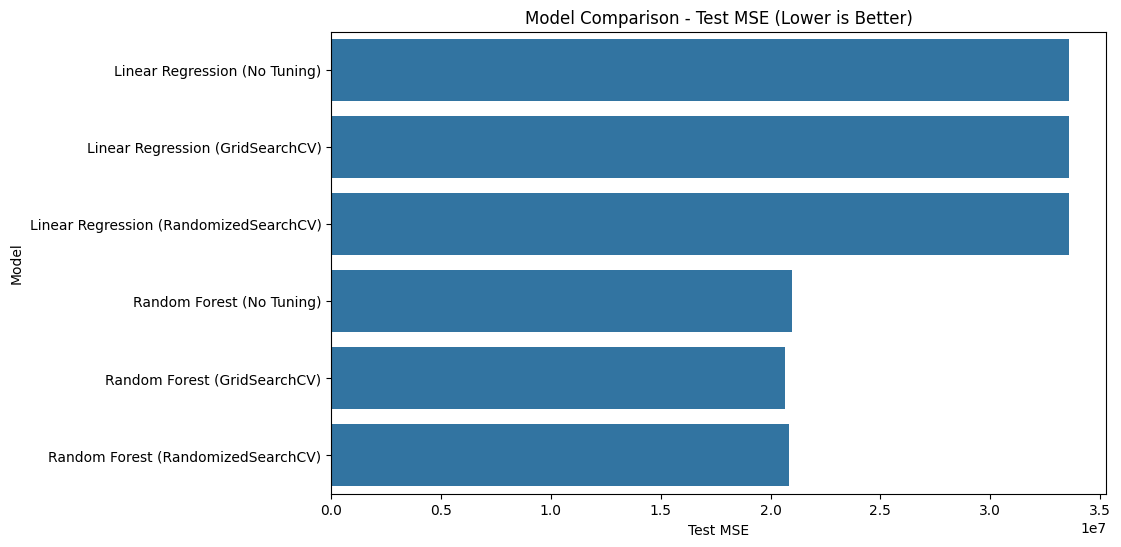

In [71]:
# Plot Test MSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Test MSE', y='Model', data=scores_df)
plt.title('Model Comparison - Test MSE (Lower is Better)')
plt.show()



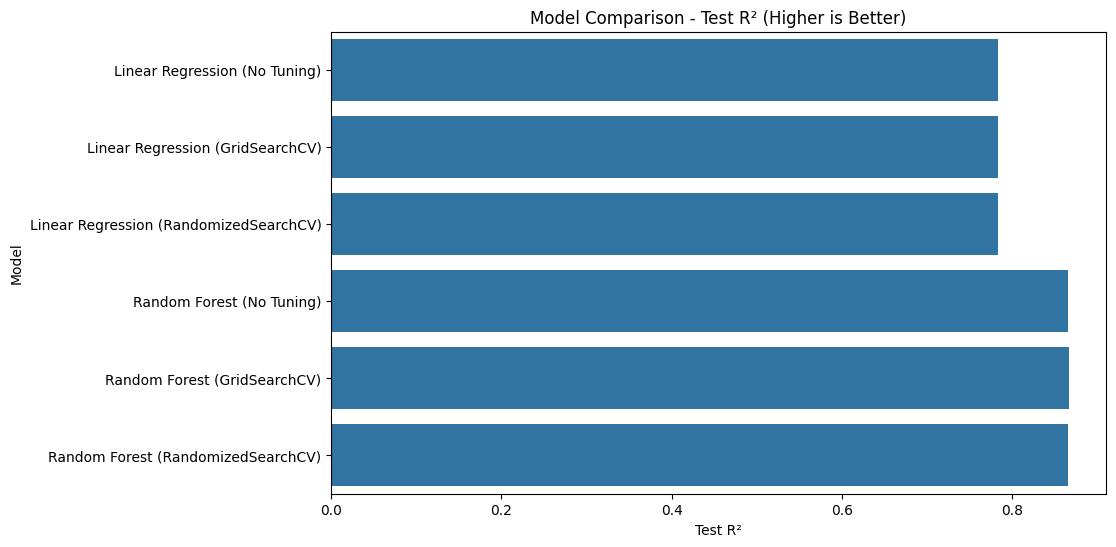

In [72]:
# Plot Test R²
plt.figure(figsize=(10, 6))
sns.barplot(x='Test R²', y='Model', data=scores_df)
plt.title('Model Comparison - Test R² (Higher is Better)')
plt.show()

# Detailed Analysis


In [74]:
# Best model based on Test MSE
best_mse_model = scores_df.loc[scores_df['Test MSE'].idxmin()]
print(f"Best Model (Lowest Test MSE): {best_mse_model['Model']}")
print(f"Test MSE: {best_mse_model['Test MSE']:.2f}, Test R²: {best_mse_model['Test R²']:.2f}")

# Best model based on Test R²
best_r2_model = scores_df.loc[scores_df['Test R²'].idxmax()]
print(f"\nBest Model (Highest Test R²): {best_r2_model['Model']}")
print(f"Test MSE: {best_r2_model['Test MSE']:.2f}, Test R²: {best_r2_model['Test R²']:.2f}")

Best Model (Lowest Test MSE): Random Forest (GridSearchCV)
Test MSE: 20666558.60, Test R²: 0.87

Best Model (Highest Test R²): Random Forest (GridSearchCV)
Test MSE: 20666558.60, Test R²: 0.87


# Compare untuned vs tuned for each model

In [75]:
for model_name in ['Linear Regression', 'Random Forest']:
    print(f"\n{model_name} Comparison:")
    model_scores = scores_df[scores_df['Model'].str.contains(model_name)]
    print(model_scores[['Model', 'Test MSE', 'Test R²']])
    print(f"Improvement in MSE (Untuned to GridSearchCV): {(model_scores.iloc[0]['Test MSE'] - model_scores.iloc[1]['Test MSE']):.2f}")
    print(f"Improvement in R² (Untuned to GridSearchCV): {(model_scores.iloc[1]['Test R²'] - model_scores.iloc[0]['Test R²']):.2f}")


Linear Regression Comparison:
                                    Model      Test MSE   Test R²
0           Linear Regression (No Tuning)  3.359692e+07  0.783593
1        Linear Regression (GridSearchCV)  3.359692e+07  0.783593
2  Linear Regression (RandomizedSearchCV)  3.359692e+07  0.783593
Improvement in MSE (Untuned to GridSearchCV): 0.00
Improvement in R² (Untuned to GridSearchCV): 0.00

Random Forest Comparison:
                                Model      Test MSE   Test R²
3           Random Forest (No Tuning)  2.095708e+07  0.865010
4        Random Forest (GridSearchCV)  2.066656e+07  0.866881
5  Random Forest (RandomizedSearchCV)  2.084688e+07  0.865719
Improvement in MSE (Untuned to GridSearchCV): 290524.59
Improvement in R² (Untuned to GridSearchCV): 0.00


#Feature Importance/Coefficients for the Best Model



Feature Importance for Random Forest (GridSearchCV):
            Feature  Importance
3        smoker_yes    0.618881
1               bmi    0.211403
0               age    0.132899
2          children    0.018016
7          sex_male    0.005523
4  region_northwest    0.004976
5  region_southeast    0.004684
6  region_southwest    0.003619


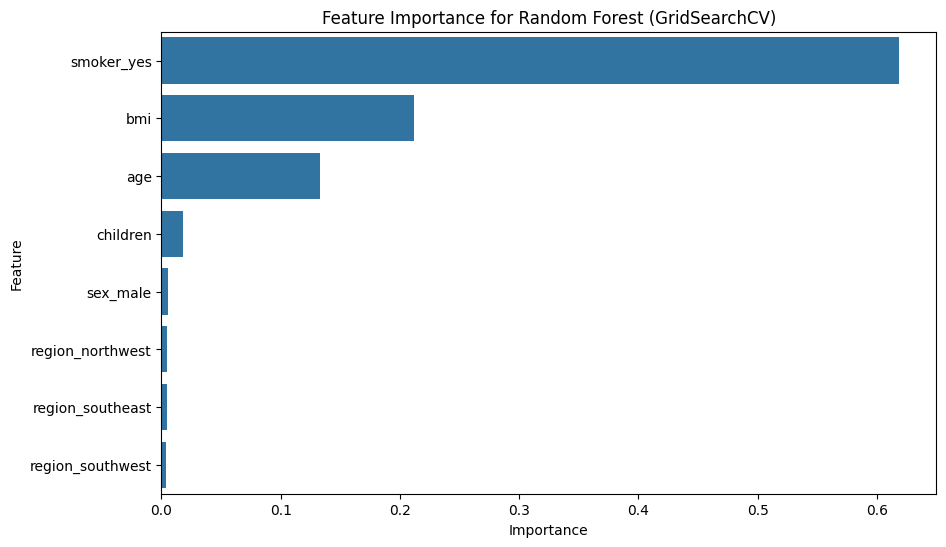

In [76]:
# Get the best model's instance
best_model_instance = best_mse_model['Model Instance']
best_model_name = best_mse_model['Model']

# Feature importance for Random Forest
if 'Random Forest' in best_model_name:
    print(f"\nFeature Importance for {best_model_name}:")
    importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model_instance.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print(importances)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importances)
    plt.title(f'Feature Importance for {best_model_name}')
    plt.show()

# Coefficients for Linear Regression
if 'Linear Regression' in best_model_name:
    print(f"\nCoefficients for {best_model_name}:")
    coefs = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model_instance.coef_
    })
    print(coefs)

    # Plot coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coefs)
    plt.title(f'Coefficients for {best_model_name}')
    plt.show()